<a href="https://colab.research.google.com/github/tingjhenjiang/python_ML_ntu_spring2019/blob/master/wk10_RNN_on_imdb_comment_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Keras
## 用RNN做情意分析

In [ ]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [ ]:
%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, History
from keras.datasets import imdb # 讀入 IMDB 電影數據庫
#fix loading imdb dataset problem: https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa

In [ ]:
total_num_words = 10000 #自然語言處理領域的問題中決定要用到多少字
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=total_num_words)

### 送入神經網路的輸入處理

老師建議：雖然 RNN 是可以處理不同長度的輸入, 在寫程式時還是要

* 設輸入文字長度的上限
* 把每段文字都弄成一樣長, 太短的後面補上 0

In [ ]:
#找出長度最長的影評
vectorized_len = np.vectorize(len)
length_of_each_comment = vectorized_len(x_train)
pad_until_length = round(np.amax(length_of_each_comment)/8,0).astype(int)

In [ ]:
x_train_ped = sequence.pad_sequences(x_train, maxlen=pad_until_length)
x_test_ped = sequence.pad_sequences(x_test, maxlen=pad_until_length)

## 決定神經網路架構

* 將 10000 維的文字壓到 O 維 by "word embedding" ；避免用1-hot 處理 1 萬個字造成用 1 萬維的向量表示：浪費記憶空間
* 然後用 O 個 LSTM
* 最後一個 output, 直接用 sigmoid 送出

In [ ]:
model = Sequential()
model.add(Embedding(total_num_words, 64)) #目標壓縮成多少維度
model.add(LSTM(50)) #幾個神經元
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 663,051
Trainable params: 663,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train_ped, y_train,
         batch_size=32,
         epochs=3)

Epoch 1/3
25000/25000 [==============================] - 1099s 44ms/step - loss: 0.4376 - acc: 0.7954
Epoch 2/3
25000/25000 [==============================] - 1127s 45ms/step - loss: 0.2512 - acc: 0.9022
Epoch 3/3
25000/25000 [==============================] - 1553s 62ms/step - loss: 0.2031 - acc: 0.9242


## 檢視結果

### 預測情形

In [ ]:
score = model.evaluate(x_test_ped, y_test)

25000/25000 [==============================] - 231s 9ms/step


In [ ]:
print('測試資料的 loss', score[0])
print('測試資料的正確率', score[1])

測試資料的 loss 0.8484413851189614
測試資料的正確率 0.85104


In [ ]:
plt.plot(model.history["acc"])
plt.title("training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

TypeError: 'History' object is not subscriptable

In [ ]:
plt.plot(model.history["val_acc"],color="yellow")
plt.title("testing accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

### 原始評論

In [ ]:
word_to_id = imdb.get_word_index()
word_to_id={k:v for k,v in word_to_id.items()} #(v+3-1)
word_to_id["<PAD>"] = 0
#word_to_id["<START>"] = 1
#word_to_id["<UNK>"] = 2
id_to_word = {value:key for key,value in word_to_id.items()}

def translate_and_show_comment(comment_i, comments, dictionary):
    print(' '.join(dictionary[id] for id in comments[comment_i] ))

In [ ]:
#translate_and_show_comment(10,x_test,id_to_word)
id_to_word[0]

'<PAD>'

## 儲存結果

In [ ]:
modelfilename = 'wk10_RNN_model_for_imdb.h5'
#model.save(modelfilename)
from keras.models import load_model
model = load_model(modelfilename)

# Keras in TF2.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import functools

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    num_words=None, maxlen=None
    #path='imdb.npz', skip_top=0, seed=113, start_char=1, oov_char=2, index_from=3, **kwargs,    
)

In [3]:
maxlen = max([len(x) for x in x_train])
allcomments = [item for sublist in x_train for item in sublist] #functools.reduce(lambda sum, elem: set(sum).union(set(elem)), x_train, [])
allcomments = np.sort(np.unique(np.asarray(allcomments)))
num_words = allcomments[-1]+1
#num_words = len(allcomments)
print(num_words)

88587


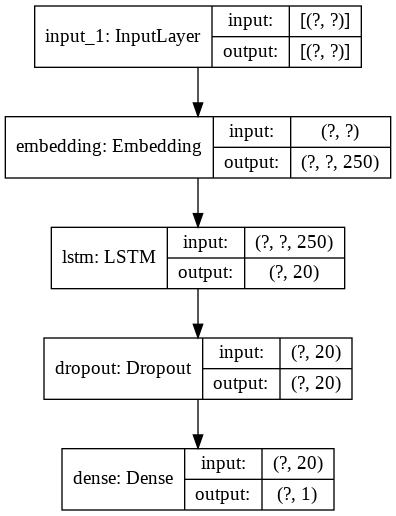

In [4]:
inputlayer = tf.keras.Input(
    shape=(None,)
    #, batch_size=None, name=None, dtype=None, sparse=False, tensor=None, ragged=False, **kwargs
)
embedlayer = tf.keras.layers.Embedding(
    input_dim=num_words, output_dim=250, mask_zero = True
    #, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
)(inputlayer)
lstmlayer = tf.keras.layers.LSTM(
    units=20, activation='tanh'
    #,recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
    #recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=2, return_sequences=False,
    #return_state=False, go_backwards=False, stateful=False, time_major=False, unroll=False, **kwargs
)(embedlayer)
dropoutlayer = tf.keras.layers.Dropout(
    rate=0.2
    #, noise_shape=None, seed=None, **kwargs
)(lstmlayer)
outputlayer = tf.keras.layers.Dense(1, activation='sigmoid')(dropoutlayer)
model = tf.keras.Model(inputs=inputlayer, outputs=outputlayer)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(), #沒有to_categorical時可以用sparse_categorical_crossentropy
              metrics=['accuracy'],
              )
#model.summary()
tf.keras.utils.plot_model(
    model, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [5]:
x_training = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen) #np.asarray([np.asarray(x for x in x_train)])
#x_training = [np.array(x) for x in x_train]
#x_training = [x for x in x_train]
#x_training = np.array(x_training)
#x_training = np.array(x_train)#.astype(np.int32)
#empty = np.ndarray(shape=(None,))
x_training = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen) #np.asarray([np.asarray(x for x in x_test)])
x_testing = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen) #np.asarray([np.asarray(x for x in x_test)])
print("x_train[0] is {}".format(x_train[0]))
print("x_training[0] is {}".format(x_training[0]))
print("type(x_train[0]) is {}".format(type(x_train[0])))
print("type(x_training[0]) is {}".format(type(x_training[0])))
print("type(x_train) is {}".format(type(x_train)))
print("type(x_training) is {}".format(type(x_training)))
try:
    print("x_training[0].dtype is {}".format(x_training[0].dtype))
    print("x_training.dtype is {}".format(x_training.dtype))
except:
    pass

x_train[0] is [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
x_training[0] is [  0 

In [7]:
history = model.fit(x_training, y_train, batch_size=768, epochs=3, verbose=1, validation_data=(x_testing, y_test))#

Epoch 1/3
33/33 [==============================] - 242s 7s/step - loss: 0.5876 - accuracy: 0.7297 - val_loss: 0.4537 - val_accuracy: 0.8123
Epoch 2/3
33/33 [==============================] - 243s 7s/step - loss: 0.3562 - accuracy: 0.8647 - val_loss: 0.3770 - val_accuracy: 0.8443
Epoch 3/3
33/33 [==============================] - 243s 7s/step - loss: 0.2826 - accuracy: 0.9010 - val_loss: 0.3858 - val_accuracy: 0.8469


In [10]:
print("Evaluate on test data")
results = model.evaluate(x_testing, y_test, batch_size=512)
print("test loss, test acc:", results)
predictions = model.predict(x_testing[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
49/49 [==============================] - 33s 677ms/step - loss: 0.3858 - accuracy: 0.8469
test loss, test acc: [0.3857516944408417, 0.8469200134277344]
predictions shape: (3, 1)


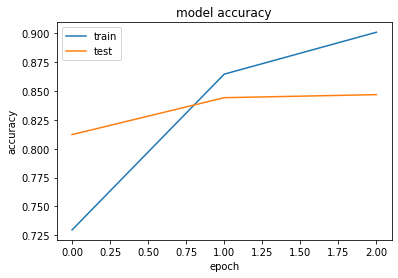

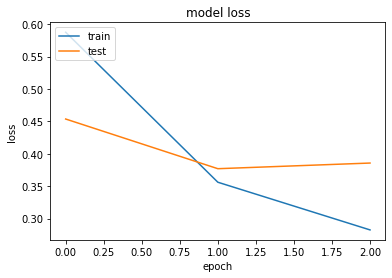

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()